In [ ]:
# def get_h_from_config(model_name: str) -> float:
#     base_path = Path("/home/mc/gold/logs/GOLD/SafetyCarButton1Gymnasium-v0-cost-80")
#     config_path = base_path / model_name / "config.yaml"
#     try:
#         with open(config_path, "r") as f:
#             config = yaml.load(f, Loader=yaml.FullLoader)
#         return config.get("h", None)
#     except Exception as e:
#         print(f"Failed to read {config_path}: {e}")
#         return None


# df3["h"] = df3["Model"].apply(get_h_from_config)
# df3.to_csv(guided_cvpo_results_file_path, index=False)

In [2]:
import pandas as pd
import yaml
from pathlib import Path

guided_cvpo_results_file_path = (
    "/home/mc/gold/logs/GOLD/SafetyCarButton1Gymnasium-v0-cost-80/eval_result.csv"
)
default_cvpo_results_file_path = (
    "/home/mc/gold/logs/SafetyCarButton1Gymnasium-v0-cost-80/eval_result.csv"
)
default_bc_results_file_path = (
    "/home/mc/gold/logs/OfflineCarButton1Gymnasium-v0-cost-80/eval_result.csv"
)
df1 = pd.read_csv(guided_cvpo_results_file_path)
df2 = pd.read_csv(default_cvpo_results_file_path)
df3 = pd.read_csv(default_bc_results_file_path)

common_columns = list(set(df1.columns) & set(df2.columns) & set(df3.columns))

In [3]:
print(df1.columns)
print(df2.columns)
print(df3.columns)

Index(['Task', 'Model', 'Teacher Model', 'Cost Limit', 'Seed', 'Best',
       'Reward', 'Cost', 'Length', 'h'],
      dtype='object')
Index(['Task', 'Model', 'Cost Limit', 'Seed', 'Best', 'Reward', 'Cost',
       'Length'],
      dtype='object')
Index(['Task', 'Model', 'Cost Limit', 'Seed', 'Best', 'Target Cost', 'Reward',
       'Normalized Reward', 'Cost', 'Normalized Cost', 'Length'],
      dtype='object')


In [4]:
print(df1.shape)
print(df2.shape)
print(df3.shape)

(54, 10)
(6, 8)
(6, 11)


In [5]:
# 找出三者共同的欄位
common_columns = list(set(df1.columns) & set(df2.columns) & set(df3.columns))

# 加上額外的欄位
extra_columns = ["Teacher Model", "h"]
all_columns = list(set(common_columns + extra_columns))


# 對每個 df 補齊缺失欄位（用 NaN 填）
def ensure_columns(df, columns):
    for col in columns:
        if col not in df.columns:
            df[col] = pd.NA
    return df[columns]


df1_fixed = ensure_columns(df1, all_columns)
df2_fixed = ensure_columns(df2, all_columns)
df3_fixed = ensure_columns(df3, all_columns)

# 合併三個 df
combined_df = pd.concat([df1_fixed, df2_fixed, df3_fixed], ignore_index=True)

In [6]:
print(combined_df.shape)
display(combined_df.head())

(66, 10)


,Length,Cost Limit,Model,Seed,Best,h,Cost,Reward,Task,Teacher Model
0,1000.0,80.0,BCExpert_CVPO_cost80.0_gamma0.97_n_step2_step_...,10,True,250,278.38,9.552503,SafetyCarButton1Gymnasium-v0,/home/mc/gold/logs/OfflineCarButton1Gymnasium-...
1,1000.0,80.0,BCExpert_CVPO_cost80.0_gamma0.97_n_step2_step_...,10,False,125,323.06,6.152405,SafetyCarButton1Gymnasium-v0,/home/mc/gold/logs/OfflineCarButton1Gymnasium-...
2,1000.0,80.0,BCExpert_CVPO_cost80.0_gamma0.97_n_step2_step_...,10,True,125,196.02,3.092313,SafetyCarButton1Gymnasium-v0,/home/mc/gold/logs/OfflineCarButton1Gymnasium-...
3,1000.0,80.0,BCExpert_CVPO_cost80.0_gamma0.97_n_step2_step_...,10,False,250,321.66,10.798709,SafetyCarButton1Gymnasium-v0,/home/mc/gold/logs/OfflineCarButton1Gymnasium-...
4,1000.0,80.0,BCExpert_CVPO_cost80.0_gamma0.97_n_step2_seed3...,30,False,375,87.34,2.721219,SafetyCarButton1Gymnasium-v0,/home/mc/gold/logs/OfflineCarButton1Gymnasium-...


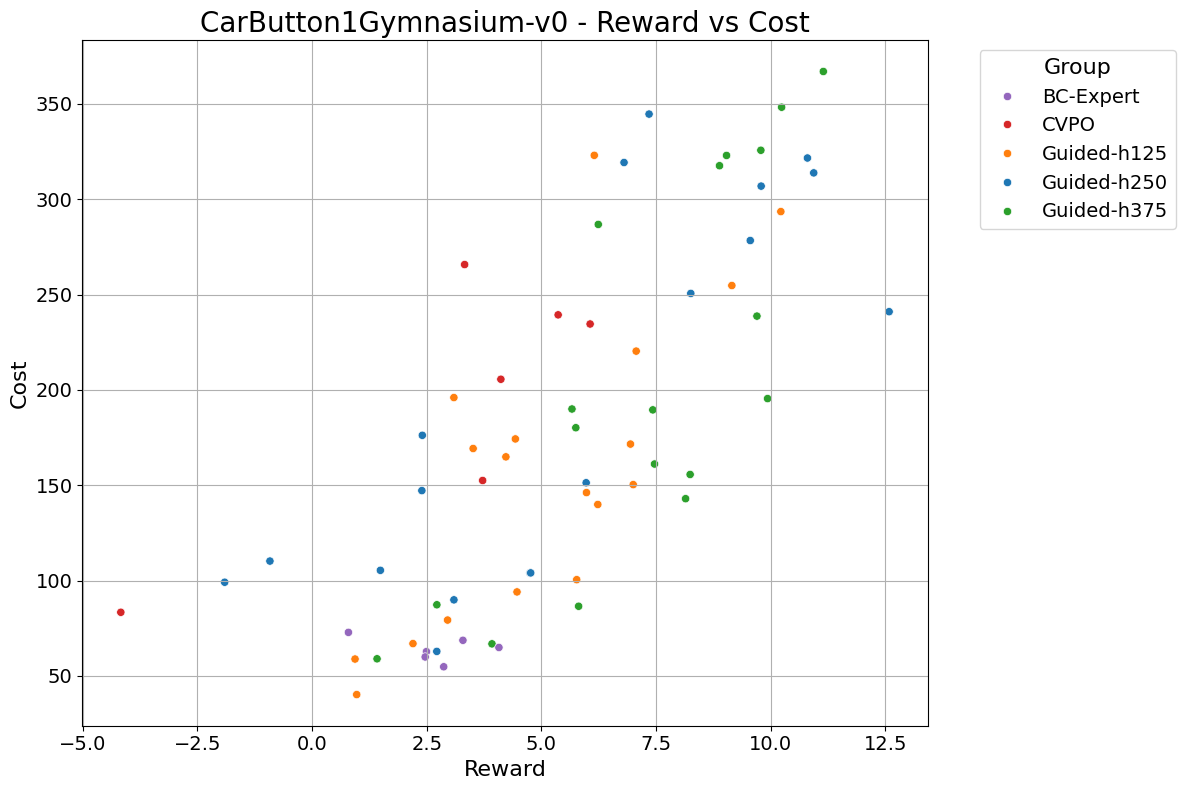

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# 分組 function
def assign_group(row):
    model = row["Model"]
    teacher = str(row.get("Teacher Model", ""))
    h_val = row.get("h", None)

    if pd.isna(model):
        return "Unknown"
    if model.startswith("BC_bc_modeexpert"):
        return "BC-Expert"
    elif model.startswith("cvpo"):
        return "CVPO"
    elif model.startswith("BCExpert_CVPO"):
        if h_val in [125, 250, 375]:
            return f"Guided-h{h_val}"
        return "Guided-Other"
    else:
        return "Other"


# 指派分組
combined_df["Group"] = combined_df.apply(assign_group, axis=1)

# 繪圖
plt.figure(figsize=(12, 8))
# 建立圖
ax = sns.scatterplot(data=combined_df, x="Reward", y="Cost", hue="Group", palette="tab10")

# 設定標題與軸標籤字體大小
plt.title("CarButton1Gymnasium-v0 - Reward vs Cost", fontsize=20)
plt.xlabel("Reward", fontsize=16)
plt.ylabel("Cost", fontsize=16)
# 設定刻度字體大小
ax.tick_params(axis="both", labelsize=14)

# 自訂順序
desired_order = ["BC-Expert", "CVPO", "Guided-h125", "Guided-h250", "Guided-h375"]
handles, labels = ax.get_legend_handles_labels()

# 依照 desired_order 重新排序
sorted_handles_labels = sorted(
    zip(labels, handles), key=lambda x: desired_order.index(x[0])
)
sorted_labels, sorted_handles = zip(*sorted_handles_labels)

# 設定 legend
plt.legend(
    sorted_handles,
    sorted_labels,
    title="Group",
    bbox_to_anchor=(1.05, 1),
    title_fontsize=16,
    fontsize=14,
    loc="upper left",
)

plt.grid(True)
plt.tight_layout()
plt.show()

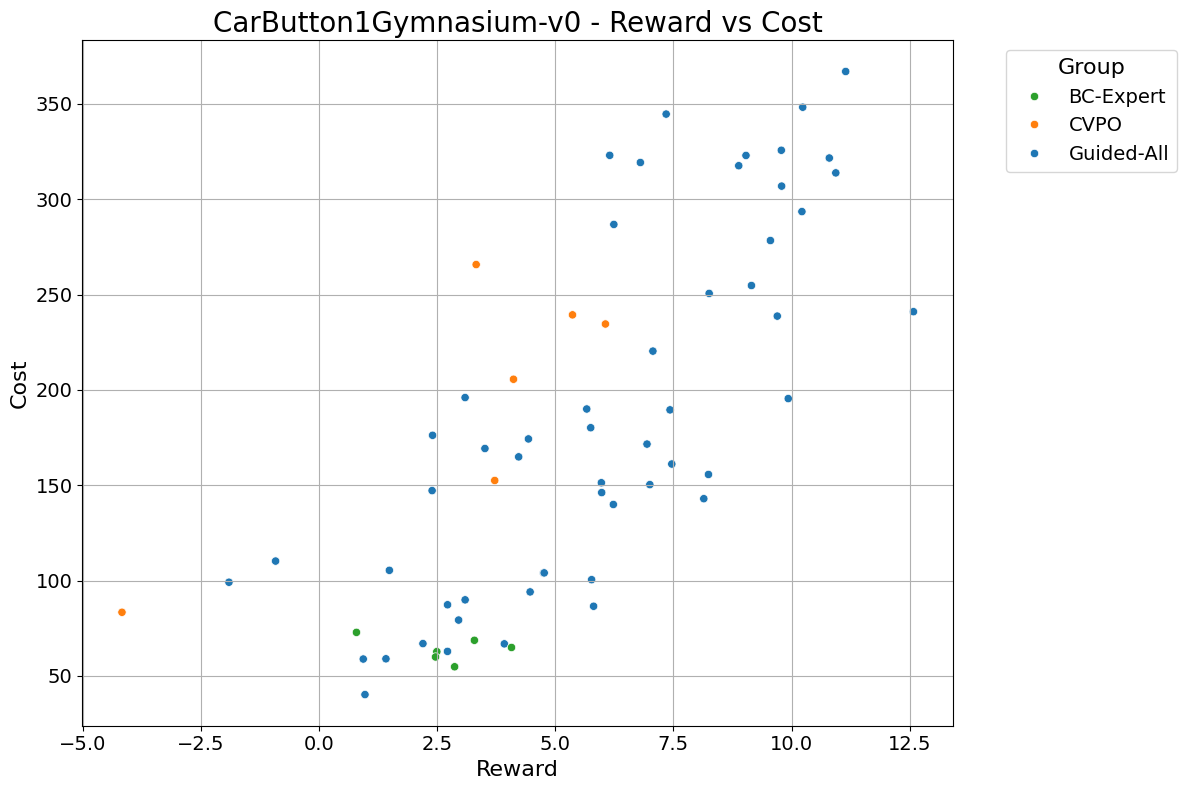

In [12]:
# 分組 function
def assign_group_join_guided(row):
    model = row["Model"]
    teacher = str(row.get("Teacher Model", ""))
    h_val = row.get("h", None)

    if pd.isna(model):
        return "Unknown"
    if model.startswith("BC_bc_modeexpert"):
        return "BC-Expert"
    elif model.startswith("cvpo"):
        return "CVPO"
    elif model.startswith("BCExpert_CVPO"):
        return "Guided-All"
    else:
        return "Other"


# 指派分組
combined_df["Group"] = combined_df.apply(assign_group_join_guided, axis=1)

# 繪圖
plt.figure(figsize=(12, 8))
# 建立圖
ax = sns.scatterplot(
    data=combined_df, x="Reward", y="Cost", hue="Group", palette="tab10"
)

# 設定標題與軸標籤字體大小
plt.title("CarButton1Gymnasium-v0 - Reward vs Cost", fontsize=20)
plt.xlabel("Reward", fontsize=16)
plt.ylabel("Cost", fontsize=16)
# 設定刻度字體大小
ax.tick_params(axis="both", labelsize=14)

# 自訂順序
desired_order = ["BC-Expert", "CVPO", "Guided-All"]
handles, labels = ax.get_legend_handles_labels()

# 依照 desired_order 重新排序
sorted_handles_labels = sorted(
    zip(labels, handles), key=lambda x: desired_order.index(x[0])
)
sorted_labels, sorted_handles = zip(*sorted_handles_labels)

# 設定 legend
plt.legend(
    sorted_handles,
    sorted_labels,
    title="Group",
    title_fontsize=16,
    fontsize=14,
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
)
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
import pandas as pd
import numpy as np

# 目標分組
individual_groups = ["BC-Expert", "CVPO", "Guided-h125", "Guided-h250", "Guided-h375"]
guided_all_group_names = ["Guided-h125", "Guided-h250", "Guided-h375"]

# 過濾個別 group
filtered_df = combined_df[combined_df["Group"].isin(individual_groups)]

# 統計：mean, std, count
group_stats = (
    filtered_df.groupby("Group")[["Reward", "Cost"]]
    .agg(["mean", "std", "count"])
    .reset_index()
)

# 改欄位名稱
group_stats.columns = [
    "Group",
    "Reward_mean",
    "Reward_std",
    "Reward_count",
    "Cost_mean",
    "Cost_std",
    "Cost_count",
]

# 加入 95% CI
z = 1.96
group_stats["Reward_CI"] = (
    z * group_stats["Reward_std"] / np.sqrt(group_stats["Reward_count"])
)
group_stats["Cost_CI"] = (
    z * group_stats["Cost_std"] / np.sqrt(group_stats["Cost_count"])
)
group_stats["N"] = group_stats["Reward_count"]

# 重排欄位
group_stats = group_stats[
    [
        "Group",
        "N",
        "Reward_mean",
        "Reward_std",
        "Reward_CI",
        "Cost_mean",
        "Cost_std",
        "Cost_CI",
    ]
]

# 計算 Guided-All
guided_df = combined_df[combined_df["Group"].isin(guided_all_group_names)]
N = len(guided_df)
reward_mean = guided_df["Reward"].mean()
reward_std = guided_df["Reward"].std()
reward_CI = z * reward_std / np.sqrt(N)

cost_mean = guided_df["Cost"].mean()
cost_std = guided_df["Cost"].std()
cost_CI = z * cost_std / np.sqrt(N)

guided_all_stats = {
    "Group": "Guided-All",
    "N": N,
    "Reward_mean": reward_mean,
    "Reward_std": reward_std,
    "Reward_CI": reward_CI,
    "Cost_mean": cost_mean,
    "Cost_std": cost_std,
    "Cost_CI": cost_CI,
}

# 合併
group_stats = pd.concat(
    [group_stats, pd.DataFrame([guided_all_stats])], ignore_index=True
)

# 顯示表格
pd.set_option("display.float_format", lambda x: f"{x:.4f}")
display(group_stats)
# 或者儲存
group_stats.to_csv("CarButton1Gymnasium-v0_BC_CVPO.csv", index=False)

,Group,N,Reward_mean,Reward_std,Reward_CI,Cost_mean,Cost_std,Cost_CI
0,BC-Expert,6,2.6648,1.0944,0.8757,64.0067,6.3813,5.1061
1,CVPO,6,3.0702,3.6926,2.9547,196.8867,67.6755,54.1517
2,Guided-h125,18,5.0728,2.5736,1.1889,158.0244,79.3486,36.6572
3,Guided-h250,18,5.6019,4.2094,1.9446,195.9444,99.0222,45.7459
4,Guided-h375,18,7.3065,2.7092,1.2516,206.7811,100.9932,46.6565
5,Guided-All,54,5.9937,3.3298,0.8881,186.9167,94.2414,25.1363
